# Coalescent estimation using PyTorch

> Mathieu Fourment, University of Technology Sydney

First things first...

In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import torch
from torchtree.evolution.coalescent import ConstantCoalescent, PiecewiseConstantCoalescent
from torchtree.inference.hmc import hmc
from torchtree.distributions.inverse_gamma import InverseGamma
# from phylotorch.drawing import draw_tree
from torchtree.evolution.io import random_tree_from_heights
import numpy as np
from scipy.special import binom
from scipy.stats import gamma, lognorm
from scipy.special import logsumexp
from scipy import integrate
from tqdm import trange
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [88]:
torch.manual_seed(0)
np.random.seed(0)

def draw_tree(fig, tree, **kwargs):
    ax = fig.gca()

    fig_width = fig.get_dpi()

    yspace = kwargs.get('yspace', 10)
    left_offset = kwargs.get('leftOffset', 5)
    branch_width = kwargs.get('branchWidth', 2)
    taxon_font_size = kwargs.get('taxonFontSize', 12)
    branch_tip_space = kwargs.get('branchTipSpace', 1.0)
    root_length = kwargs.get('rootLength', 0.0)

    showHeights = kwargs.get('showHeights', True)
    showTaxa = kwargs.get('showTaxa', True)
    showIntervals = kwargs.get('showIntervals', True)
    showHeightLabels = kwargs.get('showHeightLabels', False)

    r = fig.canvas.get_renderer()
    scaler = float("inf")

    # keep track of coordinates for each node. Usefull for drawing the vertical branches
    coordinates = {}

    # contains a cleanup taxon name and its dimension in the plot
    taxa_labels = {}

    taxaCount = 0
    taxon_height = 0
    for node in tree:
        if len(node.children) == 0:
            taxaCount += 1

            if showTaxa:
                t = plt.text(-1, -1, node.name, alpha=0, size=taxon_font_size)
                bb = t.get_window_extent(renderer=r)
                taxa_labels[node] = (node.name, bb.width, bb.height)
                taxon_height = bb.height
                s = (fig_width - branch_tip_space - bb.width) / (
                    tree.height - node.height
                )
                scaler = min(s, scaler)

    if not showTaxa:
        scaler = fig_width / tree.height

    y = taxon_height

    yy = taxon_height + taxaCount * (yspace + taxon_height)

    for node in tree:
        x1 = ((tree.height - node.height) * scaler) + left_offset + root_length

        if node.parent is not None:
            x2 = x1 - (node.parent.height - node.height) * scaler

        if len(node.children) == 0:
            y1 = y2 = y - taxon_height * 0.5
            if showTaxa:
                ax.text(
                    x1 + branch_tip_space,
                    y - (taxon_height - branch_width) * 0.5,
                    taxa_labels[node][0],
                    va='top',
                    size=taxon_font_size,
                )
            y += yspace + taxon_height
        else:
            y1, y2 = [coordinates[c]['endY'] for c in node.children]
            # Vertical branch
            ax.plot(
                [x1, x1], [y1, y2], lw=branch_width, color='steelblue', ls='-', zorder=9
            )

            y1 = y2 = y1 + (y2 - y1) / 2.0  # midpoint between childs

            if showHeights:
                ax.text(x1 + 1.0, y1, "%.3f" % (node.height), size=taxon_font_size)

        # Horizontal branch
        if node.parent is not None:
            node_branch_length = node.parent.height - node.height
            if node_branch_length is not None and node_branch_length > 0.0:
                ax.plot(
                    [x1, x2],
                    [y1, y2],
                    lw=branch_width,
                    color='steelblue',
                    ls='-',
                    zorder=9,
                )
                coordinates[node] = {'startX': x2, 'endX': x1, 'startY': y2, 'endY': y2}
            elif node_branch_length is None and root_length > 0.0:
                ax.plot(
                    [x1, x1 - root_length],
                    [y1, y2],
                    lw=branch_width,
                    color='steelblue',
                    ls='-',
                    zorder=9,
                )

    if showIntervals:
        nodes = sorted(coordinates.keys(), key=lambda n: n.height, reverse=True)

        x2 = left_offset + root_length
        ax.plot([x2, x2], [0, yy], '--', c='black')

        for i, node in enumerate(nodes):
            x1 = coordinates[node]['endX']
            ax.plot([x1, x1], [0, yy], '--', c='black')
            ax.text((x1 - x2) / 2 + x2, 0, r'$u_{}$'.format(i + 2), size=16)
            x2 = x1
            if node.height < 1.0e-10:
                break

    if showHeightLabels:
        nodes = sorted(coordinates.keys(), key=lambda n: n.height, reverse=True)

        x2 = left_offset + root_length
        ax.plot([x2, x2], [0, yy], '--', c='black')

        for i, node in enumerate(nodes):
            x1 = coordinates[node]['endX']
            ax.plot([x1, x1], [0, yy], '--', c='black')
            ax.text(x2, yy, r'$t_{}$'.format(i + 1), size=16)
            x2 = x1
            if node.height < 1.0e-10:
                break

        ax.text(x1, yy, r'$t_{}$'.format(i + 2), size=16)

    ax.axis('off')

## The coalescent

Let the coalescent times arising from genealogy $T$ of $N$ taxa be denoted $t_N = 0 < t_{N-1}< \dots< t_1$. The number of lineages associated with each interval $u_k = t_{k-1} - t_k$ is denoted $n_k$ and the vector concatenating the number of lineages is denoted $\boldsymbol{n}$.

### Constant population size
The joint distrubtion of the coalescent times given a constant population size $\theta$ is:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n}, \theta) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, \theta)\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{\theta} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta} \right]\\
\end{align}

The waiting time until the next coalescent event is exponentially distributed with rate ${n_{k} \choose 2}\frac{1}{\theta}$.


### Non parameteric population size
Suppose the function $Ne(t)$ describes the effective population size as we move into the past. The probability to observe $t_1, \dots, t_{N-1}$ given $Ne(t)$ can be written as:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n}, Ne(t)) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, Ne(t))\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{Ne(t_{k-1})} \exp \left[ -\int_{t_{k}}^{t_{k-1}} {n_{k} \choose 2} \frac{1}{Ne(t)} dt \right]\\
\end{align}

Since the integral is intractable we assume that changes in the trajectory of $Ne(t)$ coincinde with coalescent events, a piecewise constant trajectory of the population size function can be defined as $Ne(t) = \theta_k$ for $t_k < t \leq t_{k-1}$. Plugging $Ne(t) = \sum_{k=2}^N \theta_k 1_{(t_k,t_{k-1})}(t)$ in the previous equation gives the joint distribution:

\begin{align}
p(t_1, \dots, t_{N-1} \mid \boldsymbol{n},\boldsymbol{\theta}) &= \prod_{k=2}^{N} p(t_{k-1} \mid t_k, n_k, \theta_k)\\
&= \prod_{k=2}^{N} {n_{k} \choose 2}\frac{1}{\theta_k} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta_k} \right]
\end{align}

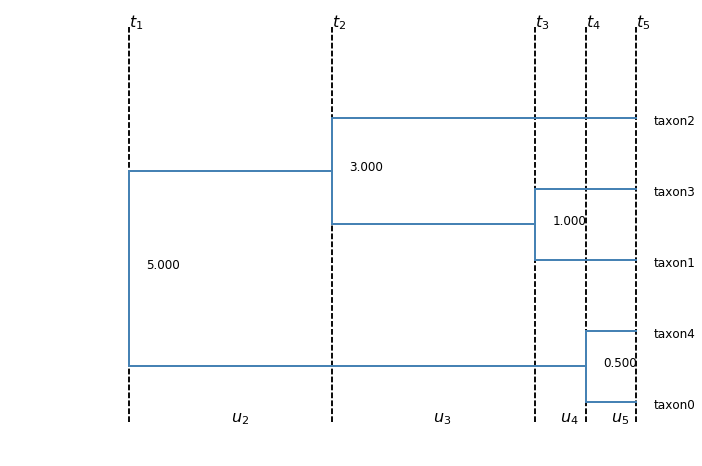

In [89]:
root = random_tree_from_heights([0.]*5, sorted([0.5,1,3,5]))
fig = plt.figure(figsize=(10,8), facecolor='w')
draw_tree(fig, root, rootLength=1,showHeightLabels=True)

## Simulated constant size coalescent

In [90]:
# simulate coalescent intervals for homochronous data
def simulate(theta, taxon_count):
    lineages = np.arange(taxon_count, 1, -1)
    cf = binom(lineages, 2)
    intervals = np.random.exponential(1.0/(cf/theta))
    return {'intervals': intervals,
            'heights': np.cumsum(intervals),
            'lineages': lineages}

# numpy function to calculate probability of intervals given population size
def constant_log_prob(intervals, lineages, theta):
    return np.sum(-np.log(theta) - binom(lineages, 2)/theta*intervals)

We are going to simulate 49 coalescent intervals using a population size of 4.  This scenario corresponds to a tree consisting of 50 homochronous taxa.

In [91]:
taxon_count = 50
true_theta = 4
sim = simulate(true_theta, taxon_count)
heights_list = list(sim['heights'])
lineages = sim['lineages']
intervals = sim['intervals']

times = heights_list

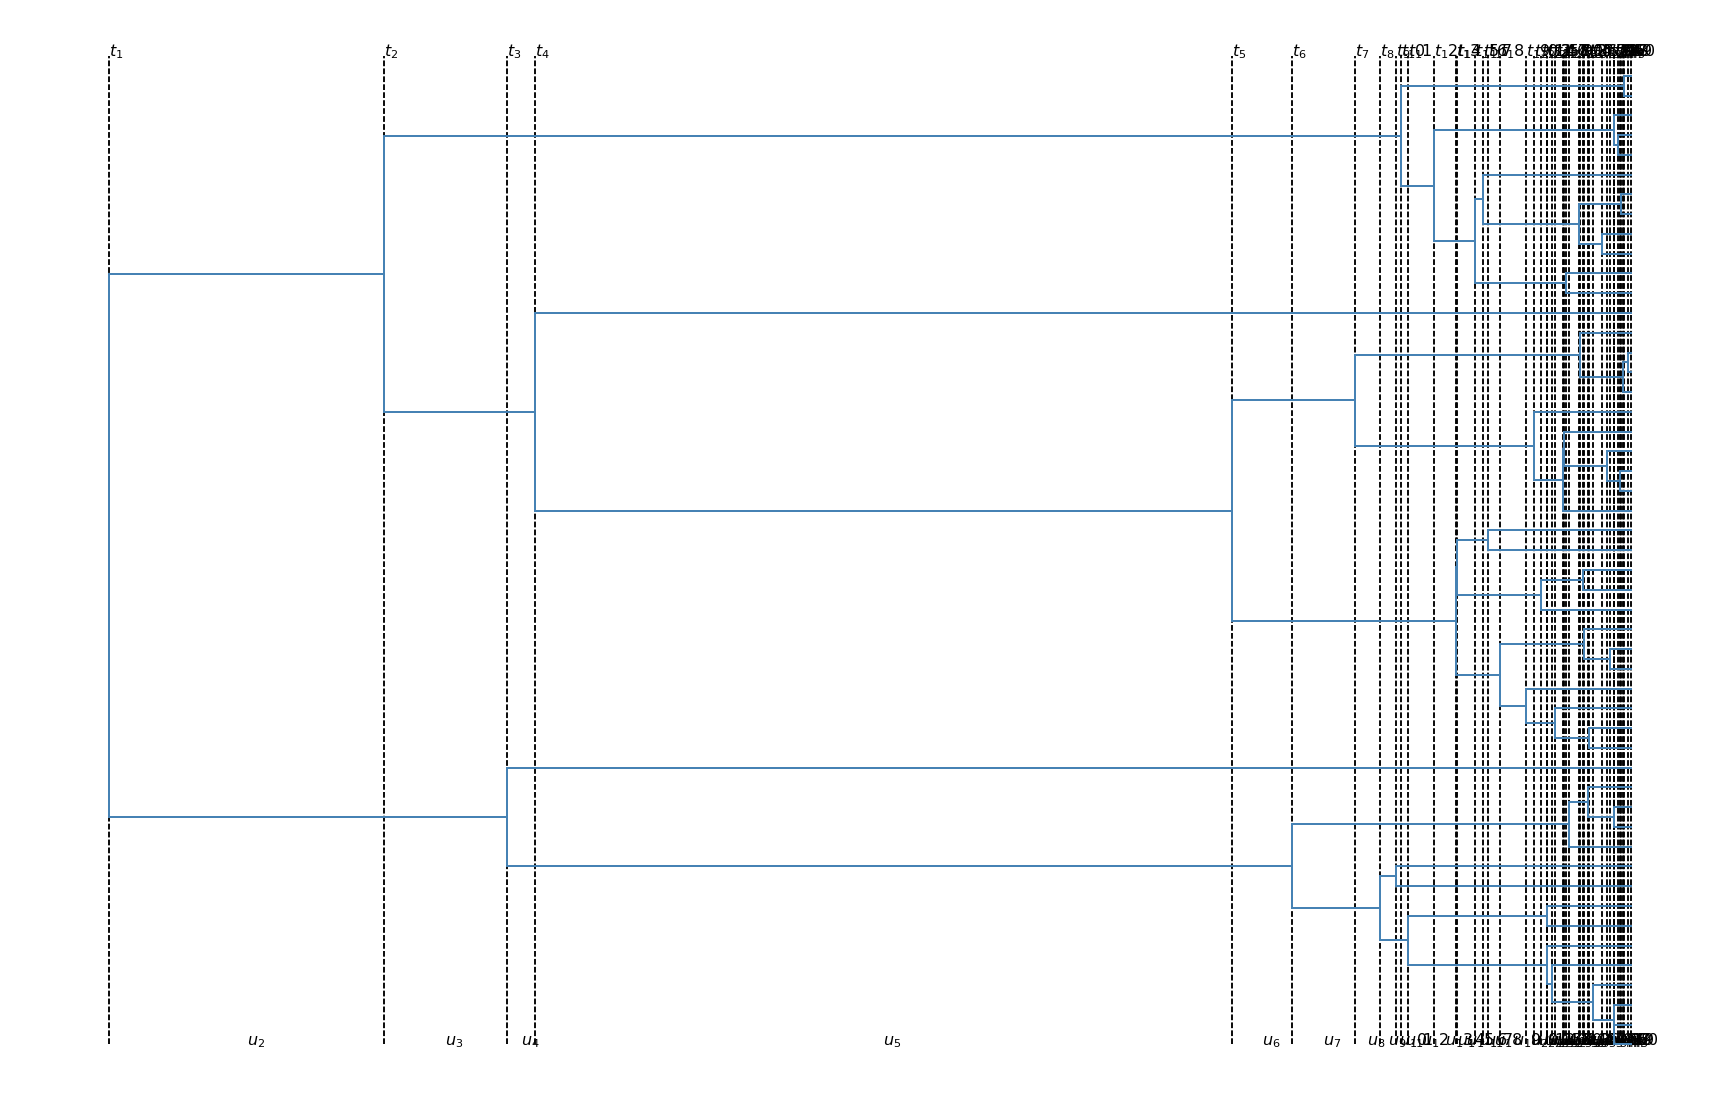

In [92]:
root = random_tree_from_heights([0.]*taxon_count, heights_list)
fig = plt.figure(figsize=(30,20), facecolor='w')
draw_tree(fig, root, rootLength=1,showTaxa=False, showHeights=False,showHeightLabels=True)

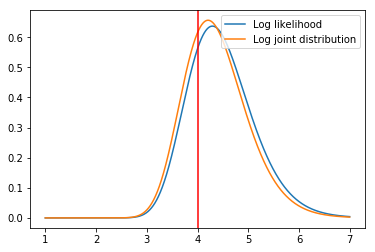

In [93]:
x = np.arange(1,7, 0.001)

# log likelihood along x
y1 = [constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), theta) for theta in x]
# log joint likelihood along x
y = [yy - np.log(theta) for theta, yy in zip(x, y1)]

y1 = np.exp(y1 - np.max(y1))
y1 = y1/np.sum(y1*0.001)

y = np.exp(y - np.max(y))
y = y/np.sum(y*0.001)

plt.plot(x, y1, label='Log likelihood')
plt.plot(x, y, label='Log joint distribution')
plt.axvline(true_theta, c='r')
plt.legend(loc="upper right")
plt.show()

## Fast approximation of population size distribution

The maximum likelihood estimator is:
$$\hat{\theta} = \frac{1}{N-1}\sum_{k=2}^N {k\choose 2} (t_{k-1} - t_k) $$

The maximum a posteriori estimator is:
$$\hat{\theta}_{MAP} = \frac{1}{N}\sum_{k=2}^N {k\choose 2} (t_{k-1} - t_k) $$

In [94]:
mle = np.sum(binom(lineages, 2) * intervals)/(taxon_count-1)
ml = constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), mle)
var = -1.0/((taxon_count-1)/mle**2 - 2.0*np.sum(binom(lineages, 2) * intervals)/(mle**3))
print('ML  theta = {:.2f} f(theta) = {:.2f} var(theta) = {:.2f}'.format(mle, ml, var))

mape = np.sum(binom(lineages, 2) * intervals)/(taxon_count)
mapp = constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), mape) - np.log(mape)
var = -1.0/((taxon_count+1)/mape**2 - 2.0*np.sum(binom(lineages, 2) * intervals)/(mape**3))
print('MAP theta = {:.2f} f(theta) = {:.2f} var(theta) = {:.2f}'.format(mape, mapp, var))

ML  theta = 4.29 f(theta) = -120.40 var(theta) = 0.38
MAP theta = 4.21 f(theta) = -121.85 var(theta) = 0.36


Using the Laplace method and the mean and variance from the normal approximation the parameters of the lognormal distribution are:

In [95]:
d2logP = (taxon_count+1)/mape**2 - 2.0*np.sum(binom(lineages, 2) * intervals)/(mape**3)
q_sigma_map = np.sqrt(-1.0/(d2logP*mape*mape))
q_mu_map = np.log(mape) + q_sigma_map*q_sigma_map
print('mu = {:.3f} sigma = {:.3f}'.format(q_mu_map, q_sigma_map))

mu = 1.457 sigma = 0.143


Similarly the parameters of the gamma distribution can be estimated:

In [96]:
q_rate_map = mape * -d2logP
q_shape_map = q_rate_map*mape + 1.0
print('shape = {:.3f} rate = {:.3f}'.format(q_shape_map, q_rate_map))

shape = 50.000 rate = 11.645


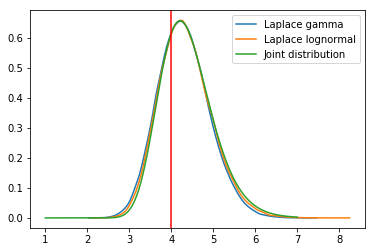

In [97]:
q_gamma = torch.distributions.Gamma(q_shape_map, q_rate_map)
xd = q_gamma.sample((100000,)).numpy().flatten()
sns.kdeplot(xd, label='Laplace gamma')

q_lnorm = torch.distributions.LogNormal(q_mu_map, q_sigma_map)
xd = q_lnorm.sample((100000,)).numpy().flatten()
sns.kdeplot(xd, label='Laplace lognormal')

plt.plot(x, y, label='Joint distribution')
plt.axvline(true_theta, c='r')
plt.legend(loc="upper right")
plt.show()

The plot above shows that the distribution of the population size parameter is somehow asymmetric, the right tail being a bit fatter than the right one. Clearly a truncated normal distribution would struggle to fit this distribution.

## Variational inference

Next we are going to estimate the population parameter of a constant size coalescent model using the intervals we just simulated. The parameter is estimated using Variational inference with the PyTorch framework. The support of the population size parameter is $\mathbb{R}^+$ so a log transformation is used to map it on the real line. It is optimized using the Adam algorithm.

It is common to use the Jeffreys prior on the population size parameter:
$$f(\theta) \propto \frac{1}{\theta}$$

The posterior distribution of the population size is:

\begin{align}
p(\theta \mid t_1, \dots, t_{N-1}, T) &\propto p(t_1, \dots, t_{N-1} \mid \theta, T) f(\boldsymbol{\theta})\\
&= \frac{1}{\theta} \prod_{k=2}^{N} \frac{1}{\theta} \exp \left[ - {n_{k} \choose 2} \frac{(t_{k-1} - t_k)}{\theta} \right]
\end{align}

Variational Bayes methods provide an analytical approximation to the posterior probability and a lower bound for the marginal likelihood.
The main idea is to choose a family of distributions $q$ parametrised with parameters $\boldsymbol{\phi}$ and to minimize the Kullback Leibler (KL) divergence from variational distribution $q$ to the posterior distribution $p$ of interest

$$ \boldsymbol{\phi}^{*} = \text{argmin}_{\boldsymbol{\phi} \in \boldsymbol{\Phi}}  \mathrm{KL}(q(\boldsymbol{\theta}; \boldsymbol{\phi}) \parallel p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})). $$

It is difficult to minimise the KL divergence directly but much easier to minimize a function that is equal to it up to a constant.
Expanding the KL divergence we get

$$\begin{aligned}
\mathrm{KL}(q(\boldsymbol{\theta}; \boldsymbol{\phi}) \parallel p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})) &= \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})] - \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta} \mid t_1, \dots, t_{N-1})] \\
  & = \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})] - \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta}, t_1, \dots, t_{N-1})] + \log p(t_1, \dots, t_{N-1})\\
    & = -\textrm{ELBO}(\boldsymbol{\phi}) + \log p(t_1, \dots, t_{N-1}),
\end{aligned}$$
where $\textrm{ELBO}(\boldsymbol{\phi}) = \mathop{\mathbb{E}}[\log p(\boldsymbol{\theta}, t_1, \dots, t_{N-1})] - \mathop{\mathbb{E}}[\log q(\boldsymbol{\theta}; \boldsymbol{\phi})]$.
This equation suggests that the $\textrm{ELBO}(\boldsymbol{\phi})$ is the lower bound of the evidence: $\log p(t_1, \dots, t_{N-1}) \geq \textrm{ELBO}(\boldsymbol{\phi})$.


Instead of minimizing KL divergence, we maximize  the evidence lower bound:
$$ \textrm{ELBO}(\boldsymbol{\phi}) = \mathop{\mathbb{E}}_{q(\boldsymbol{\theta}; \boldsymbol{\phi})}[\log p(t_1, \dots, t_{N-1}, \boldsymbol{\theta}) - \log q(\boldsymbol{\theta}; \boldsymbol{\phi})].$$


In [98]:
lr_lambda = lambda epoch: 1.0/np.sqrt(epoch+1)
sampling_times = torch.zeros([taxon_count], requires_grad=False)
heights = torch.tensor(heights_list, requires_grad=False)
node_heights = torch.cat((sampling_times, heights), 0)

def calculate_elbo_constant(q_theta):
    z = q_theta.rsample()
    logQ = q_theta.log_prob(z)
    logPrior = -z.log() # Jeffreys: 1/theta
    coalescent = ConstantCoalescent(z)
    logP = coalescent.log_prob(node_heights)
    return  logP + logPrior - logQ

## Variational distribution: lognormal

In [99]:
theta_mu = torch.randn(1, requires_grad=True)
theta_sigma = torch.randn(1, requires_grad=True)

# homochronous dataset
optimizer = torch.optim.Adam( (theta_mu, theta_sigma), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []
mu_grads = []
sigma_grads = []
mus = []
sigmas = []

def elbo_lognormal(size=1):
    elbo = 0
    q_theta = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
    for i in range(size):
        elbo += calculate_elbo_constant(q_theta)
    return elbo/size

iters = tqdm(range(50000), mininterval=1)
for epoch in iters:
    mus.append(theta_mu.item())
    sigmas.append(theta_sigma.exp().item())
    
    loss = -elbo_lognormal()
    
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    mu_grads.append(theta_mu.grad.item())
    sigma_grads.append(theta_sigma.grad.item()**2)
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_lognormal(100).item()))

  0%|          | 0/50000 [00:00<?, ?it/s]

Final ELBO: -121.43260001912266


The next two plots show the full trajectory of the ELBO on the left and the trajectory for the last 40000 iterations on the right. The ELBO has stabilized around -121.

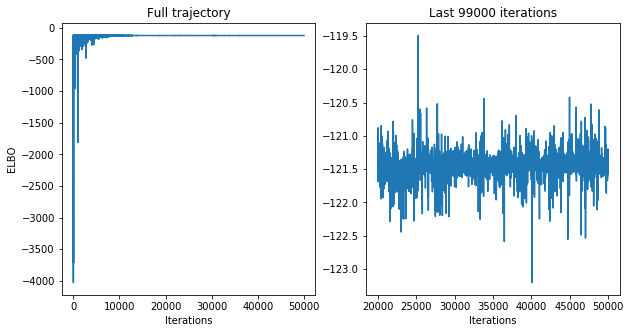

In [100]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(elbo_hist)
axes[0].set_title('Full trajectory')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('ELBO')

axes[1].plot(list(range(20000, len(elbo_hist))), elbo_hist[20000:])
axes[1].set_title('Last 99000 iterations')
axes[1].set_xlabel('Iterations')
plt.show()


This plot shows the estimated lognormal distribution (variational distribution). The red line represents the true value of the population size parameter.

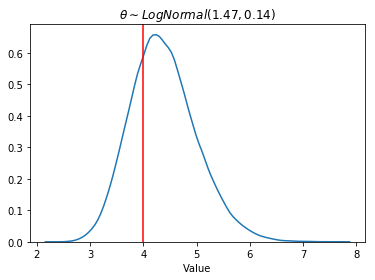

In [101]:
m = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
x = m.sample((100000,)).numpy().flatten()
sns.kdeplot(x)
plt.axvline(true_theta, c='r')
plt.xlabel('Value')
plt.title(r'$\theta \sim LogNormal({:.2f},{:.2f})$'.format(theta_mu.item(), theta_sigma.exp().item()))
plt.show()

In [102]:
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
x = np.arange(1,7, 0.001)
xt = torch.tensor(x)
mus2 = mus[:20000:50]
sigmas2 = sigmas[:20000:50]
elbos = elbo_hist[:20000:50]
def animate(i):
    ax1.clear()
    q_theta = torch.distributions.LogNormal(torch.tensor([mus2[i]]), torch.tensor([sigmas2[i]]))
    yy = q_theta.log_prob(xt).exp().numpy().flatten()

    ax1.plot(x, yy, 'k-')
    ax1.plot(x, y, label='Log joint distribution', c='r')
    ax1.text(x[6], np.max(y), 'ELBO = {:.2f}'.format(elbos[i]))

anim = animation.FuncAnimation(fig, animate, interval=100, frames=len(mus2), repeat=False)
plt.close()

## Variational distribution: inverse gamma

In [103]:
theta_alpha_i = torch.tensor([4.], requires_grad=True)
theta_beta_i = torch.tensor([4.], requires_grad=True)

optimizer = torch.optim.Adam( (theta_alpha_i, theta_beta_i), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist3 = []

def elbo_inverse_gamma(size=1):
    elbo = 0
    q_theta = InverseGamma(theta_alpha_i.exp(), theta_beta_i.exp())
    for i in range(size):
        elbo += calculate_elbo_constant(q_theta)
    return elbo/size

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    loss = -elbo_inverse_gamma()
    
    elbo_hist3.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist3[-1]), refresh=False)

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_inverse_gamma(100).item()))

  0%|          | 0/100000 [00:00<?, ?it/s]

Final ELBO: -121.42726278821755


## Variational distribution: gamma

In [104]:
theta_alpha = torch.tensor([np.log(q_shape_map)], requires_grad=True)
theta_beta = torch.tensor([np.log(q_rate_map)], requires_grad=True)

optimizer = torch.optim.Adam( (theta_alpha, theta_beta), lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist2 = []
mu_grads2 = []
sigma_grads2 = []

    
def elbo_gamma(size=1):
    elbo = 0
    q_theta = torch.distributions.Gamma(theta_alpha.exp(), theta_beta.exp())
    for i in range(size):
        z = q_theta.rsample()
        elbo += calculate_elbo_constant(q_theta)
    return elbo/size

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    loss = -elbo_gamma()
    
    elbo_hist2.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    mu_grads2.append(theta_alpha.grad.item())
    sigma_grads2.append(theta_beta.grad.item()**2)
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist2[-1]), refresh=False)
    
with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_gamma(100).item()))

  0%|          | 0/100000 [00:00<?, ?it/s]

Final ELBO: -121.44106139198804


In [105]:
def elbo_gamma_laplace(size=1):
    elbo = 0
    q_theta = torch.distributions.Gamma(q_shape_map, q_rate_map)
    for i in range(size):
        z = q_theta.rsample()
        logQ = q_theta.log_prob(z)
        logPrior = -z # Jeffreys: 1/theta
        coalescent = ConstantCoalescent(z)
        logP = coalescent.log_prob(node_heights)
        elbo += logP + logPrior - logQ
    return elbo/size

with torch.no_grad():
    print('Final ELBO: {}'.format(elbo_gamma_laplace(100).item()))

Final ELBO: -124.29661596517961


tensor([49.4862], dtype=torch.float64, grad_fn=<ExpBackward0>) tensor([11.2396], dtype=torch.float64, grad_fn=<ExpBackward0>)


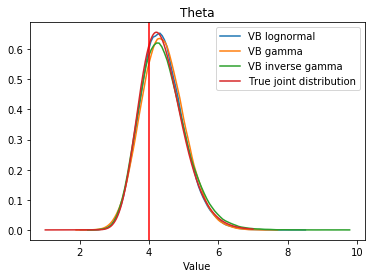

In [106]:
m = torch.distributions.LogNormal(theta_mu, theta_sigma.exp())
mg = torch.distributions.Gamma(theta_alpha.exp(), theta_beta.exp())
print(theta_alpha.exp(), theta_beta.exp())
mig = InverseGamma(theta_alpha_i.exp(), theta_beta_i.exp())
x = m.sample((100000,))
x = x.numpy().flatten()
sns.kdeplot(x, label='VB lognormal')

xg = mg.sample((100000,))
xg = xg.numpy().flatten()
sns.kdeplot(xg, label='VB gamma')

xig = mig.sample((100000,))
xig = xig.numpy().flatten()
sns.kdeplot(xig, label='VB inverse gamma')

plt.plot(np.arange(1,7, 0.001), y, label='True joint distribution')
plt.axvline(true_theta, c='r')
plt.xlabel('Value')
plt.title('Theta')

plt.legend(loc="upper right")
plt.show()

Visually the lognormal outperforms the gamma and inverse gamma distribution. The ELBO estimates can have high variance and might be of little use to discriminate between closely related models (in the KL sense).
What if we use these approximations to calculate the marginal likelihood using importance sampling with the variational distribution $q$ as the importance distribution. This yields the $\hat{p}_{\text{VBIS}}(t_1,\dots, t_{N-1})$ estimator:

$$
\hat{p}_{\text{VBIS}}(t_1,\dots, t_{N-1}) = \frac{1}{K} \sum_{i=1}^K \frac{p(t_1,\dots, t_{N-1} \mid \tilde{\boldsymbol{\theta}_i}) p(\tilde{\boldsymbol{\theta}_i})}{q_{\text{ELBO}}(\tilde{\boldsymbol{\theta}_i})}, \tilde{\boldsymbol{\theta}}_i \sim q_{\text{ELBO}}(\boldsymbol{\theta}).
$$

In [107]:
theta_mu_np = theta_mu.detach().numpy().flatten()
theta_sigma_np = theta_sigma.exp().detach().numpy().flatten()
samples = 100000
z = lognorm.rvs(theta_sigma_np, scale=np.exp(theta_mu_np), size=samples)
lq = np.log(lognorm.pdf(z, theta_sigma_np, scale=np.exp(theta_mu_np)))
lp=[constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), theta) - np.log(theta) for theta in z]
print('Lognormal log marginal = {}'.format(logsumexp(lp-lq) - np.log(samples)))

theta_alpha_np = theta_alpha.exp().detach().numpy().flatten()
theta_beta_np = theta_beta.exp().detach().numpy().flatten()
z = gamma.rvs(theta_alpha_np, scale=1.0/theta_beta_np, size=samples)
lq = np.log(gamma.pdf(z, theta_alpha_np, scale=1.0/theta_beta_np))
lp=[constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), theta) - np.log(theta) for theta in z]
print('Gamma log marginal     = {}'.format(logsumexp(lp-lq) - np.log(samples)))

ll = lambda theta : np.exp(constant_log_prob(np.array(sim['intervals']), np.array(sim['lineages']), theta) - np.log(theta) - ml)
lml, _ = np.log(integrate.quad(ll, 0, np.inf)) + ml
print('Quad log marginal      = {}'.format(lml))

Lognormal log marginal = -121.42575835190551
Gamma log marginal     = -121.42523005948057
Quad log marginal      = -121.42573966720174


## Hepatitis C Outbreak in Egypt

In [108]:
heights_list = (
        0.337539776803851, 1.47598666181676, 2.59836642809404, 10.5419856428014, 10.6808211320844, 15.3216302200854,
        32.9562682261327, 35.2648938177678, 36.7219608418798, 36.737540711423, 37.2708231729614, 37.7849554073031,
        39.4937183636496, 39.5351866235332, 40.2051118111069, 40.272699980689, 42.8275583168662, 45.0143000059112,
        46.5121661847954, 47.1448952249262, 47.504526489029, 47.9616614709545, 48.3715795210146, 48.483790544288,
        48.7943022569899, 50.4087925250658, 51.2112016897755, 51.2609695712131, 51.878675348271, 54.1904624765934,
        55.4352237750807, 55.5550828199461, 55.9082058859295, 61.1133486466791, 61.2488301435699, 61.6467848736123,
        61.8450615919513, 63.090453292149, 66.1723097114625, 66.981821939552, 68.9496036301138, 69.0585863605563,
        69.3140166961911, 70.088816523003, 70.582823656852, 72.0200679613929, 72.0372853199532, 72.1961653985567,
        72.4862745825324, 74.6256268205132, 74.6985113851702, 78.4868903769909, 79.3977257023136, 83.4281836229148,
        85.2297867264788, 87.6518990828725, 89.1434858206649, 94.7629800718393, 224.733954965067, 232.942753855407,
        251.57871299307, 277.961578642117)
taxon_count = len(heights_list) + 1
sampling_times = torch.tensor([0.0] * taxon_count, requires_grad=False)
heights = torch.tensor(heights_list, requires_grad=False)
node_heights = torch.cat((sampling_times, heights), 0)

intervals = np.array([0.0] + list(heights_list))
intervals = intervals[1:] - intervals[:-1]
lineages = list(range(taxon_count, 1, -1))
times = [1994. - x for x in heights_list]
mles = binom(lineages, 2) * intervals
mle = np.mean(mles)
print('MLE: {:.2f} log(MLE): {:.2f}'.format(mle, np.log(mle)))

MLE: 1378.86 log(MLE): 7.23


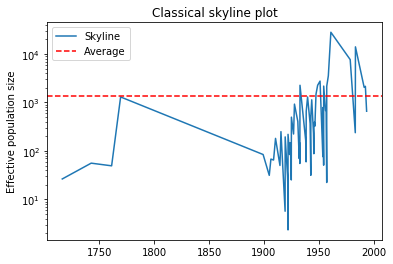

In [109]:
plt.plot(times, binom(lineages, 2) * intervals, '-', label='Skyline')
plt.title('Classical skyline plot')
plt.ylabel('Effective population size')
plt.axhline(mle, linestyle='--', c='r', label='Average')
plt.yscale('log')
plt.legend(loc="upper left")
plt.show()

## Transformation of population size parameters

\begin{align}
\tilde\theta_k &= \log\theta_k, k = 2, \dots, N \\
\Delta_i &= \tilde\theta_{i+1} - \tilde\theta_{i}, i = 2, \dots, N-1\\
\end{align}

## Meanfield on $\boldsymbol{\theta}$, centered parameterization, GMRF, and $Gamma(\tau)$

The gamma distribution is parameterized with the shape and rate parameters. The normal distribution is parameterized with the precision parameter $\tau=\frac{1}{\sigma^2}$.

\begin{align}
\tilde\theta_N &\sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i &\sim \mathit{Normal}(0, 1/\tau)\\
\tau &\sim \mathit{Gamma}(0.001,0.001)\\
\end{align}

\begin{equation*}
p_{\tilde\theta}(\tilde\theta_2, \dots, \tilde\theta_N, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{equation*}

\begin{align}
p(\theta_2, \dots, \theta_N, \tau \mid T) &= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) |\det J|\\
&= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) \left|\prod_{i=2}^N\frac{d \log \theta_i}{d \theta_i}\right|\\
&= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) \left|\prod_{i=2}^N\frac{1}{\theta_i}\right|
\end{align}

### Variational model: meanfield gamma

Meanfield gamma distribution on $\boldsymbol{\theta}$:
$$ q(\boldsymbol\theta, \tau; \mu, \sigma, \boldsymbol\alpha, \boldsymbol\beta) = LogNormal(\tau; \mu, \sigma) \prod_{i=1}^N Gamma(\theta_i; \alpha_i, \beta_i)$$

In [110]:
# parameters of the gamma distributions for the population size parameters
thetas_shape = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
thetas_rate = torch.tensor([4.]*(taxon_count-1), requires_grad=True)
# parameters of the normal distributions for the population size differences
tau_mu = torch.tensor([0.1], requires_grad=True)
tau_sigma = torch.tensor([0.1], requires_grad=True)

optimizer = torch.optim.Adam((thetas_shape, thetas_rate, tau_mu, tau_sigma),
                              lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# gamma prior on precision parameter tau
prior_tau = torch.distributions.Gamma(0.001, 0.001)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.Gamma(thetas_shape.exp(), thetas_rate.exp())
    q_tau = torch.distributions.LogNormal(tau_mu, tau_sigma.exp())
    thetas = q_theta.rsample()
    tau = q_tau.rsample()
    
    logQ = q_theta.log_prob(thetas).sum() + q_tau.log_prob(tau)
    
    # GMRF prior
    scale = torch.tensor([1.0])/tau.sqrt()
    prior_gmrf = torch.distributions.Normal(0, scale)
    z = thetas.log()
    logPrior = prior_gmrf.log_prob(z[:-1] - z[1:]).sum() + prior_tau.log_prob(tau) + prior_theta.log_prob(z[0])
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(node_heights) - z.sum()
    loss = -(logP + logPrior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

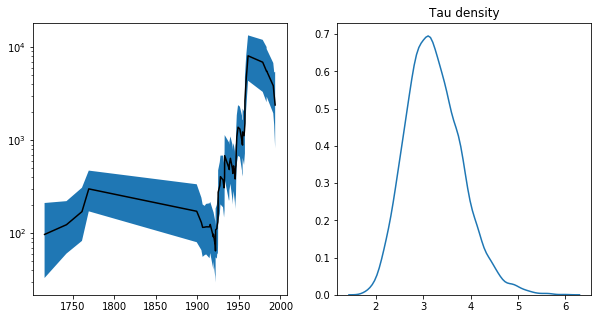

In [111]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
z = torch.distributions.Gamma(thetas_shape.exp(), thetas_rate.exp()).sample((1000,1))
thetas_gam = np.squeeze(z.numpy())
quants = np.quantile(thetas_gam, (0.025, 0.5, 0.975), 0)

axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

taus = torch.distributions.LogNormal(tau_mu, tau_sigma.exp()).sample((10000,))
taus = np.squeeze(taus.numpy())
sns.kdeplot(taus, ax=axes[1])
axes[1].set_title('Tau density')

plt.show()

### Variational model: meanfield lognormal

Meanfield lognormal distribution on $\boldsymbol{\theta}$:
$$ q(\theta, \tau; \boldsymbol\mu, \boldsymbol\sigma) = LogNormal(\tau; \mu_\tau, \sigma_\tau) \prod_{i=1}^N LogNormal(\theta_i; \mu_i, \sigma_i)$$

In [112]:
thetas_mu = torch.tensor([8.]*(taxon_count-1), requires_grad=True)
thetas_sigma = torch.tensor([-2.]*(taxon_count-1), requires_grad=True)
tau_mu = torch.tensor([4.2], requires_grad=True)
tau_sigma = torch.tensor([-1.7], requires_grad=True)

optimizer = torch.optim.Adam((thetas_mu, thetas_sigma,
                             tau_mu, tau_sigma),
                              lr=1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# gamma prior on precision parameter tau
prior_tau = torch.distributions.Gamma(0.001, 0.001)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

# GMRF weights
# midpoint distances
# weights = torch.tensor((intervals[1:] + intervals[:-1])/2.0, requires_grad=False)
weights = torch.tensor([1.0]*(taxon_count - 2), requires_grad=False)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.LogNormal(thetas_mu, thetas_sigma.exp())
    q_tau = torch.distributions.LogNormal(tau_mu, tau_sigma.exp())
    thetas = q_theta.rsample()
    z = thetas.log()
    tau = q_tau.rsample()
    
    logQ = q_theta.log_prob(thetas).sum() + q_tau.log_prob(tau)
    
    # GMRF prior
    prior_gmrf = torch.distributions.Normal(0, weights/tau.sqrt())
    
    logPrior = prior_gmrf.log_prob(z[:-1] - z[1:]).sum() + prior_tau.log_prob(tau) + prior_theta.log_prob(z[0])
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(node_heights) - z.sum()

    loss = -(logP + logPrior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    mu_grads.append(thetas_mu.grad)
    sigma_grads.append(thetas_sigma.grad)
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)        

  0%|          | 0/100000 [00:00<?, ?it/s]

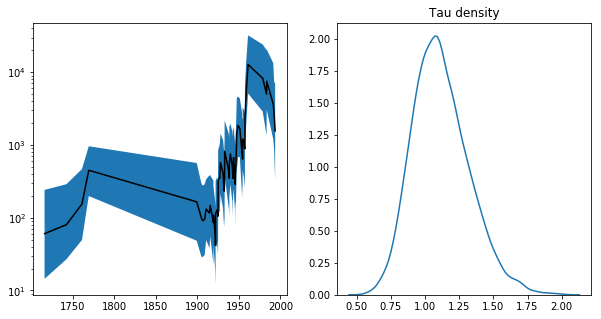

In [113]:
f, axes = plt.subplots(1, 2, figsize=(10,5))

q_thetas = torch.distributions.LogNormal(thetas_mu, thetas_sigma.exp())
thetas = np.squeeze(q_thetas.sample((1000,)).numpy())
mm =np.mean(thetas, 0)
quants = np.quantile(thetas, (0.025, 0.5, 0.975), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

taus = torch.distributions.LogNormal(tau_mu, tau_sigma.exp()).sample((10000,))
taus = np.squeeze(taus.numpy())
sns.kdeplot(taus, ax=axes[1])
axes[1].set_title('Tau density')

plt.show()

## Meanfield on $\boldsymbol{\Delta}$, non-centered parameterization, GMRF, and $Gamma(\tau)$

\begin{equation*}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, 1/\tau)\\
\tau \sim \mathit{Gamma}(0.001,0.001)\\
p_{\tilde\theta}(\tilde\theta_2, \dots, \tilde\theta_N, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{equation*}

\begin{align}
p(\tilde\theta_N, \Delta_2, \dots, \Delta_{N-1}, \tau \mid T) &= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) |det J| \\
&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) \left|\prod_{i=2}^N \frac{d}{d \Delta_i}\tilde\theta_{i-1} + \Delta_i \right|\\
&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T)\\
%&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) \left|\prod_{i=2}^N \frac{d}{d \Delta_i} \tilde\theta_1 + \sum_{j=2}^{i}\Delta_j \right|\\
\end{align}

### Variational model: meanfield normal

Meanfield normal distribution on $\boldsymbol{\Delta}$ and $\tilde\theta_1$:
$$ q(\tilde\theta_N, \Delta_2, \dots, \Delta_{N-1}, \tau; \mu, \sigma) = LogNormal(\tau; \mu_\tau, \sigma_\tau) Normal(\tilde\theta_N; \mu_N, \sigma_N) \prod_{i=2}^{N-1} Normal(\Delta_i; \mu_i, \sigma_i)$$

In [114]:
theta_mu = torch.tensor([8.0], requires_grad=True)
theta_sigma = torch.tensor([-2.0], requires_grad=True)
deltas_mu = torch.tensor([-0.05]*(taxon_count-2), requires_grad=True)
deltas_sigma = torch.tensor([-2.2]*(taxon_count-2), requires_grad=True)
tau_mu = torch.tensor([4.2], requires_grad=True)
tau_sigma = torch.tensor([-1.7], requires_grad=True)

optimizer = torch.optim.Adam((theta_mu, theta_sigma, 
                              deltas_mu, deltas_sigma, 
                              tau_mu, tau_sigma),
                              lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# gamma prior on precision parameter tau
prior_tau = torch.distributions.Gamma(0.001, 0.001)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
    q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
    q_tau = torch.distributions.LogNormal(tau_mu, tau_sigma.exp())
    log_theta = q_theta.rsample()
    deltas = q_deltas.rsample()
    tau = q_tau.rsample()
    
    logQ = q_theta.log_prob(log_theta) + q_deltas.log_prob(deltas).sum() + q_tau.log_prob(tau)
    
    thetas = torch.cat((log_theta, deltas)).cumsum(0).exp()
    
    # GMRF prior
    scale = torch.tensor([1.0])/tau.sqrt()
    prior_gmrf = torch.distributions.Normal(0, scale)
    
    log_prior = prior_theta.log_prob(log_theta) + prior_gmrf.log_prob(deltas).sum() + prior_tau.log_prob(
            tau) + prior_theta.log_prob(log_theta[0])
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(node_heights)

    loss = -(logP + log_prior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

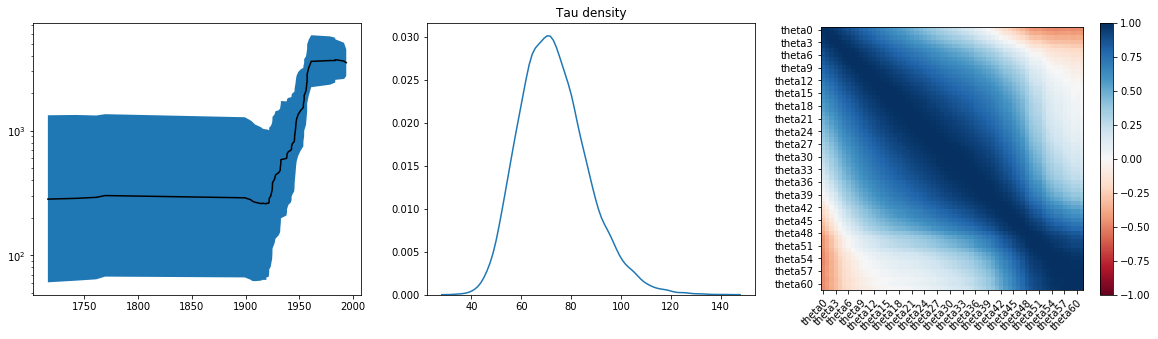

In [115]:
f, axes = plt.subplots(1, 3, figsize=(20,5))

q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
theta = np.squeeze(q_theta.sample((10000,)).numpy())
theta = np.expand_dims(theta, axis=1)
deltas = np.squeeze(q_deltas.sample((10000,)).numpy())

thetas = np.exp(np.concatenate((theta, deltas), axis=1).cumsum(1))
mm =np.mean(thetas, 0)
quants = np.quantile(thetas, (0.025, 0.5, 0.975), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

taus = torch.distributions.LogNormal(tau_mu, tau_sigma.exp()).sample((10000,))
taus = taus.numpy().flatten()
sns.kdeplot(taus, ax=axes[1])
axes[1].set_title('Tau density')

axes[2].set_xticks(np.arange(0, thetas.shape[1], 3))
axes[2].set_yticks(np.arange(0, thetas.shape[1], 3))
im = axes[2].imshow(np.corrcoef(np.cov(np.transpose(thetas))), vmin=-1, vmax=1, cmap='RdBu')
axes[2].set_xticklabels(['theta{}'.format(i) for i in np.arange(0, thetas.shape[1], 3)])
axes[2].set_yticklabels(['theta{}'.format(i) for i in np.arange(0, thetas.shape[1], 3)])

plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im, ax=axes[2])

plt.show()

## Meanfield on $\boldsymbol\theta$, centered parameterization, GMRF, and $Cauchy(\tau)$

\begin{equation*}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, \gamma)\\
\gamma \sim \mathit{Cauchy}(0,\zeta)\\
\zeta = 0.015\\
p_{\tilde\theta}(\tilde\theta_2, \dots, \tilde\theta_N, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{equation*}

\begin{align}
p(\theta_2, \dots, \theta_N, \tau \mid T) &= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) |\det J|\\
&= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) \left|\prod_{i=2}^N\frac{d \log \theta_i}{d \theta_i}\right|\\
&= p_{\tilde\theta}(\log\theta_2, \dots, \log\theta_N, \tau \mid T) \left|\prod_{i=2}^N\frac{1}{\theta_i}\right|
\end{align}


### Variational model: meanfield lognormal

Meanfield lognormal distribution on $\boldsymbol{\theta}$:
$$ q(\theta, \tau; \boldsymbol\mu, \boldsymbol\sigma) = LogNormal(\tau; \mu_\tau, \sigma_\tau) \prod_{i=2}^N LogNormal(\theta_i; \mu_i, \sigma_i)$$

In [116]:
thetas_mu = torch.tensor([0.]*(taxon_count-1), requires_grad=True)
thetas_sigma = torch.tensor([1.]*(taxon_count-1), requires_grad=True)
gam_mu = torch.tensor([0.1], requires_grad=True)
gam_sigma = torch.tensor([0.1], requires_grad=True)

optimizer = torch.optim.Adam((thetas_mu, thetas_sigma,
                             gam_mu, gam_sigma),
                              lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# cauchy prior on precision parameter gam
cauchy_prior = torch.distributions.Cauchy(0.0, 0.015)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_thetas = torch.distributions.LogNormal(thetas_mu, thetas_sigma.exp())
    q_gam = torch.distributions.LogNormal(gam_mu, gam_sigma.exp())
    thetas = q_thetas.rsample()
    gam = q_gam.rsample()
    z = thetas.log()
    
    logQ = q_thetas.log_prob(thetas).sum() + q_gam.log_prob(gam)

    # GMRF prior
    prior_gmrf = torch.distributions.Normal(0, gam)
    
    logPrior = prior_gmrf.log_prob(z[:-1] - z[1:]).sum() + cauchy_prior.log_prob(gam) + prior_theta.log_prob(z[0]) - z.sum()
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(node_heights)

    loss = -(logP + logPrior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

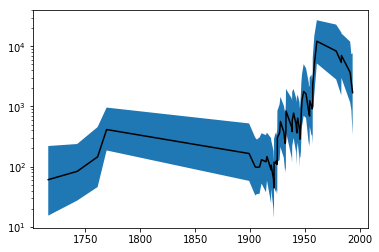

In [117]:
m = torch.distributions.LogNormal(thetas_mu, thetas_sigma.exp())
z=m.sample((1000,1))
thetas = np.squeeze(z.numpy())
mm =np.mean(thetas,0)
quants = np.quantile(thetas, (0.025, 0.5, 0.975), 0)
plt.plot(times, quants[1], 'k-')
plt.fill_between(times, quants[0], quants[2])
plt.yscale('log')
plt.show()

## Meanfield on $\boldsymbol\Delta$, non-centered parameterization, GMRF, and $Cauchy(\gamma)$

\begin{equation*}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, \gamma\zeta)\\
\gamma \sim \mathit{Cauchy}(0,1)\\
\zeta = 0.015\\
p_{\tilde\theta}(\tilde\theta_2, \dots, \tilde\theta_N, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{equation*}

\begin{align}
p(\tilde\theta_N, \Delta_2, \dots, \Delta_{N-1}, \tau \mid T) &= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) |det J| \\
&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) \left|\prod_{i=2}^N \frac{d}{d \Delta_i}\tilde\theta_{i-1} + \Delta_i \right|\\
&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T)\\
%&= p_{\tilde\theta}(\tilde\theta_N, \tilde\theta_2 + \Delta_2, \dots, \tilde\theta_{N-1} + \Delta_{N-1}, \tau \mid T) \left|\prod_{i=2}^N \frac{d}{d \Delta_i} \tilde\theta_1 + \sum_{j=2}^{i}\Delta_j \right|\\
\end{align}

### Variational model: meanfield normal

Meanfield normal distribution on $\boldsymbol{\Delta}$ and $\tilde\theta_N$:
$$ q(\tilde\theta_N, \Delta_2, \dots, \Delta_{N-1}, \tau; \mu, \sigma) = LogNormal(\tau; \mu_\tau, \sigma_\tau) Normal(\tilde\theta_N; \mu_N, \sigma_N) \prod_{i=2}^{N-1} Normal(\Delta_i; \mu_i, \sigma_i)$$

In [118]:
theta_mu = torch.tensor([8.0], requires_grad=True)
theta_sigma = torch.tensor([-2.0], requires_grad=True)
deltas_mu = torch.tensor([-0.05]*(taxon_count-2), requires_grad=True)
deltas_sigma = torch.tensor([-2.2]*(taxon_count-2), requires_grad=True)
gam_mu = torch.tensor([4.2], requires_grad=True)
gam_sigma = torch.tensor([-1.7], requires_grad=True)

optimizer = torch.optim.Adam((theta_mu, theta_sigma, 
                              deltas_mu, deltas_sigma, 
                              gam_mu, gam_sigma),
                              lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# cauchy prior on precision parameter gam
cauchy_prior = torch.distributions.Cauchy(0.0, 1.0)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
    q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
    q_gam = torch.distributions.LogNormal(gam_mu, gam_sigma.exp())
    
    log_theta = q_theta.rsample()
    deltas = q_deltas.rsample()
    gam = q_gam.rsample()
    
    logQ = q_theta.log_prob(log_theta) + q_deltas.log_prob(deltas).sum() + q_gam.log_prob(gam)
    
    thetas = torch.cat((log_theta, deltas)).cumsum(0).exp()
    
    # GMRF prior
    prior_gmrf = torch.distributions.Normal(0, gam*0.015)
    
    log_prior = prior_theta.log_prob(log_theta) + prior_gmrf.log_prob(deltas).sum() + cauchy_prior.log_prob(gam) + prior_theta.log_prob(log_theta[0])
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(node_heights)

    loss = -(logP + log_prior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

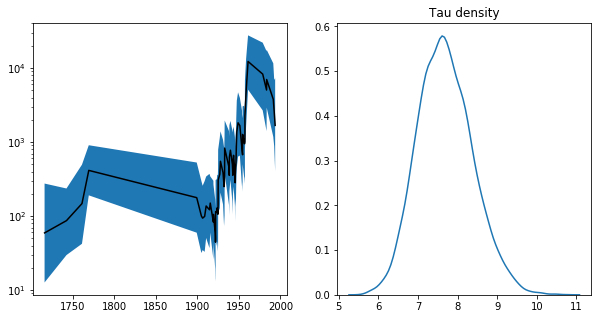

In [119]:
f, axes = plt.subplots(1, 2, figsize=(10,5))

q_thetas = torch.distributions.LogNormal(thetas_mu, thetas_sigma.exp())
thetas = np.squeeze(q_thetas.sample((1000,)).numpy())
mm =np.mean(thetas, 0)
quants = np.quantile(thetas, (0.025, 0.5, 0.975), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

gams = torch.distributions.LogNormal(gam_mu, gam_sigma.exp()).sample((10000,))
gams = gams.numpy().flatten()
sns.kdeplot(gams, ax=axes[1])
axes[1].set_title('Tau density')

plt.show()

## Meanfield on $\boldsymbol\Delta$, non-centered, HSMRF

\begin{equation*}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, \zeta \boldsymbol\tau\gamma)\\
\boldsymbol\tau \sim \mathit{Cauchy}(0,1)\\
\gamma \sim \mathit{Cauchy}(0,1)\\
\zeta = 0.01
\end{equation*}


In [120]:
theta_mu = torch.tensor([8.0], requires_grad=True)
theta_sigma = torch.tensor([-2.0], requires_grad=True)
deltas_mu = torch.tensor([-0.05]*(taxon_count-2), requires_grad=True)
deltas_sigma = torch.tensor([-2.2]*(taxon_count-2), requires_grad=True)
# local scales
taus_mu = torch.tensor([4.]*(taxon_count-2), requires_grad=True)
taus_sigma = torch.tensor([-2.]*(taxon_count-2), requires_grad=True)
# global scale
gam_mu = torch.tensor([4.], requires_grad=True)
gam_sigma = torch.tensor([-2.], requires_grad=True)

optimizer = torch.optim.Adam((theta_mu, theta_sigma, 
                              deltas_mu, deltas_sigma, 
                              tau_mu, tau_sigma, 
                              gam_mu, gam_sigma),
                              lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# cauchy prior on precision parameter gam
cauchy_prior = torch.distributions.Cauchy(0.0, 1.0)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)
for epoch in iters:
    q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
    q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
    q_gam = torch.distributions.LogNormal(gam_mu, gam_sigma.exp())
    q_taus = torch.distributions.LogNormal(taus_mu, taus_sigma.exp())
    
    log_theta = q_theta.rsample()
    deltas = q_deltas.rsample()
    taus = q_taus.rsample()
    gam = q_gam.rsample()
    
    logQ = q_theta.log_prob(log_theta) + q_deltas.log_prob(deltas).sum() + q_gam.log_prob(gam) + q_taus.log_prob(taus).sum()
    
    thetas = torch.cat((log_theta, deltas)).cumsum(0).exp()
    
    # HSMRF prior
    prior_hsmrf =  torch.distributions.Normal(0, gam*taus*0.015)
    
    logPrior = prior_theta.log_prob(log_theta) + prior_hsmrf.log_prob(deltas).sum() + cauchy_prior.log_prob(taus).sum() + cauchy_prior.log_prob(gam)
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(node_heights)

    loss = -(logP + logPrior - logQ)
    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

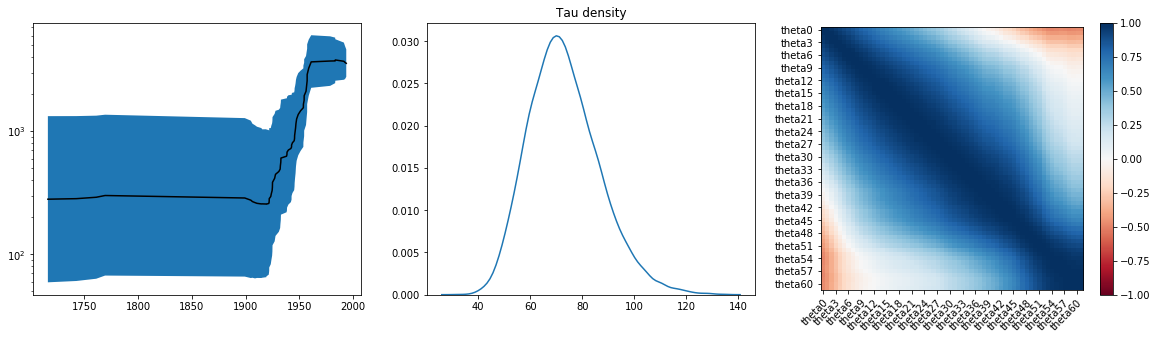

In [121]:
f, axes = plt.subplots(1, 3, figsize=(20,5))

q_theta = torch.distributions.Normal(theta_mu, theta_sigma.exp())
q_deltas = torch.distributions.Normal(deltas_mu, deltas_sigma.exp())
theta = np.squeeze(q_theta.sample((10000,)).numpy())
theta = np.expand_dims(theta, axis=1)
deltas = np.squeeze(q_deltas.sample((10000,)).numpy())

thetas = np.exp(np.concatenate((theta, deltas), axis=1).cumsum(1))
mm =np.mean(thetas, 0)
quants = np.quantile(thetas, (0.025, 0.5, 0.975), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

taus = torch.distributions.LogNormal(tau_mu, tau_sigma.exp()).sample((10000,))
taus = taus.numpy().flatten()
sns.kdeplot(taus, ax=axes[1])
axes[1].set_title('Tau density')

axes[2].set_xticks(np.arange(0, thetas.shape[1], 3))
axes[2].set_yticks(np.arange(0, thetas.shape[1], 3))
im = axes[2].imshow(np.corrcoef(np.cov(np.transpose(thetas))), vmin=-1, vmax=1, cmap='RdBu')
axes[2].set_xticklabels(['theta{}'.format(i) for i in np.arange(0, thetas.shape[1], 3)])
axes[2].set_yticklabels(['theta{}'.format(i) for i in np.arange(0, thetas.shape[1], 3)])

plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im, ax=axes[2])

plt.show()

## Low rank, centered, GMRF

\begin{equation*}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta_N^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, 1/\tau)\\
\tau \sim \mathit{Gamma}(0.001,0.001)\\
p_{\tilde\theta}(\tilde\theta_2, \dots \tilde\theta_{N}, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{equation*}

Low rank Normal distribution:
$$ q(\tilde\theta_2, \dots, \tilde\theta_N, \tau; \boldsymbol{\mu}, \boldsymbol\Sigma) = Normal(\boldsymbol{\tilde\theta}, \tau; \boldsymbol{\mu}, \boldsymbol\Sigma)$$

The covariance matrix is defined as $\boldsymbol\Sigma = F F^T + D$ where $F$ is the $N \times rank$ factor matrix and $D$ is the $N \times N$ diagonal part of low-rank form of covariance matrix.

In [122]:
rank = 3

lowrank_mus = torch.tensor([4.0]*taxon_count, requires_grad=True)
cov_factor = torch.tensor([1.0]*(rank*taxon_count)).reshape((taxon_count,rank)).requires_grad_()
cov_diag = torch.tensor([1.0]*taxon_count, requires_grad=True)

optimizer = torch.optim.Adam((lowrank_mus, cov_factor, cov_diag),
                              lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

g = torch.distributions.Gamma(0.001, 0.001)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)

for epoch in iters:
    
    q_low = torch.distributions.LowRankMultivariateNormal(lowrank_mus, cov_factor, cov_diag.exp())
    z = q_low.rsample()

    zthetas, ztau = torch.split(z, (taxon_count-1,1))
    thetas = zthetas.exp()
    tau = ztau.exp()
    
    logQ = q_low.log_prob(z)
    
    # GMRF prior
    scale = torch.tensor([1.0])/tau.sqrt()
    gmrf = torch.distributions.Normal(0, scale)
    
    logPrior = torch.sum(gmrf.log_prob(z[:-2] - z[1:-1])) + g.log_prob(tau) + prior_theta.log_prob(z[0]) + ztau
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(node_heights)
    loss = -(logP + logPrior - logQ)

    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

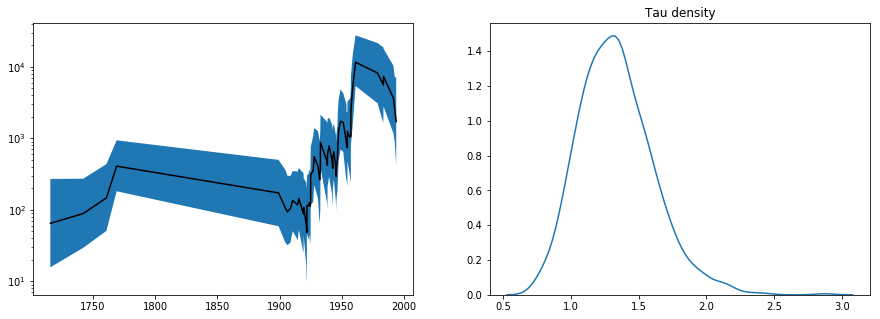

In [123]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

q_low = torch.distributions.LowRankMultivariateNormal(lowrank_mus, cov_factor, cov_diag.exp())
z = q_low.sample((1000,))
zthetas, ztau = torch.split(z, (taxon_count-1,1), dim=1)
thetas = zthetas.exp().numpy()
mm =np.mean(thetas, 0)
quants = np.quantile(thetas, (0.025, 0.5, 0.975), 0)
axes[0].plot(times, quants[1], 'k-')
axes[0].fill_between(times, quants[0], quants[2])
axes[0].set_yscale('log')

taus = ztau.exp().numpy().flatten()
sns.kdeplot(taus, ax=axes[1])
axes[1].set_title('Tau density')

plt.show()

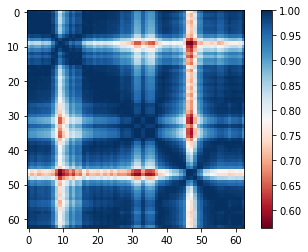

In [124]:
cov = cov_factor @ cov_factor.T + cov_diag.exp()
im=plt.imshow(np.corrcoef(cov.detach().numpy()), cmap='RdBu')
plt.colorbar(im)
plt.show()

# Full rank, centered, GMRF

\begin{equation*}
\tilde\theta_N \sim \mathit{Normal}(\tilde\theta_N^{MLE}, 10) \\
\Delta_i \sim \mathit{Normal}(0, 1/\tau)\\
\tau \sim \mathit{Gamma}(0.001,0.001)\\
p_{\tilde\theta}(\tilde\theta_2, \dots \tilde\theta_{N}, \tau \mid T) \propto p(T \mid \theta_2, \dots, \theta_N) p(\tau) p(\tilde\theta_N)  \prod_{i=2}^{N-1} p(\Delta_i|0,1/\tau)
\end{equation*}

Full-rank Normal distribution:
$$ q(\tilde\theta_2, \dots, \tilde\theta_N, \tau; \boldsymbol{\mu}, \boldsymbol\Sigma) = Normal(\boldsymbol{\tilde\theta}, \tau; \boldsymbol{\mu}, \boldsymbol\Sigma)$$

In [125]:
dim = taxon_count #includes \tau
full_mus = torch.tensor([4.0] + [0.0]*(dim-2) + [4], requires_grad=True)
full_tril = torch.tensor([.01]*int((dim*dim-dim)/2 + dim), requires_grad=True)

optimizer = torch.optim.Adam((full_mus, full_tril),
                              lr=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
elbo_hist = []

# gamma prior on precision parameter tau
g = torch.distributions.Gamma(0.001, 0.001)
prior_theta = torch.distributions.Normal(np.log(mle), 10)

iters = tqdm(range(100000), mininterval=1)

for epoch in iters:
    tril = torch.zeros((dim, dim))
    tril_indices = torch.tril_indices(row=dim, col=dim, offset=0)
    tril[tril_indices[0], tril_indices[1]] = full_tril
    tril[range(dim),range(dim)] = tril.diag().exp()
    
    q_full = torch.distributions.MultivariateNormal(full_mus, scale_tril=tril)

    z = q_full.rsample()

    logQ = q_full.log_prob(z)

    zthetas, ztau = torch.split(z, (taxon_count-1,1))
    thetas = zthetas.exp()
    tau = ztau.exp()
    
    # GMRF prior
    scale = torch.tensor([1.0])/tau.sqrt()
    gmrf = torch.distributions.Normal(0, scale)
    
    logPrior = torch.sum(gmrf.log_prob(z[:-2]-z[1:-1])) + g.log_prob(tau) + prior_theta.log_prob(z[0]) + ztau
    skyride = PiecewiseConstantCoalescent(thetas)
    logP = skyride.log_prob(node_heights)
    loss = -(logP + logPrior - logQ)

    elbo_hist.append(-loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    iters.set_description('ELBO: {}'.format(elbo_hist[-1]), refresh=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

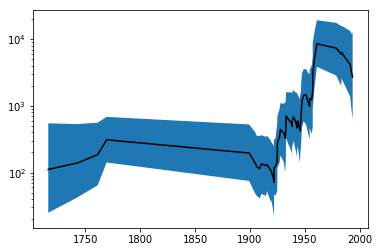

In [126]:
tril = torch.zeros((dim, dim))
tril_indices = torch.tril_indices(row=dim, col=dim, offset=0)
tril[tril_indices[0], tril_indices[1]] = full_tril
tril[range(dim),range(dim)] = tril.diag().exp()

m = torch.distributions.MultivariateNormal(full_mus, scale_tril=tril)

z = m.sample((1000,1))
thetas = np.squeeze(z.exp().numpy())[:,0:-1]
mm = np.mean(thetas,0)
quants = np.quantile(thetas, (0.025, 0.5, 0.975), 0)
plt.plot(times, quants[1], 'k-')
plt.fill_between(times, quants[0], quants[2])
plt.yscale('log')
plt.show()

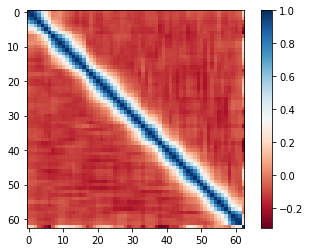

In [127]:
im = plt.imshow(np.corrcoef(torch.mm(tril, tril.t()).detach().numpy()), cmap='RdBu')
plt.colorbar(im)
plt.show()

# HMC

In [128]:
prior_theta = torch.distributions.Normal(np.log(mle), 10)
g = torch.distributions.Gamma(0.001, 0.001)

def log_joint_gamma(params):
    z, ztau = torch.split(params, (params.shape[0]-1, 1))
    tau = ztau.exp()
    scale = torch.tensor([1.0])/tau.sqrt()
    gmrf = torch.distributions.Normal(0, scale)
    thetas = z.exp()
    
    log_prior = prior_theta.log_prob(z[0]) + g.log_prob(tau) + gmrf.log_prob(z[:-1]-z[1:]).sum() + ztau
    skyride = PiecewiseConstantCoalescent(thetas)
    return skyride.log_prob(node_heights) + log_prior

beta = torch.tensor([4.0]*(taxon_count-1) + [2.0]).float()
samples, probs = hmc(beta, log_joint_gamma, iters=range(10000), step_size=0.01)

In [129]:
def log_joint_gamma_deltas(params):
    z, ztau = torch.split(params, (params.shape[0]-1, 1))
    tau=ztau.exp()
    scale = torch.tensor([1.0])/tau.sqrt()
    gmrf = torch.distributions.Normal(0, scale)
    thetas = z.cumsum(0).exp()
    
    log_prior = prior_theta.log_prob(z[0]) +  g.log_prob(tau) + gmrf.log_prob(z[1:]).sum() + ztau
    skyride = PiecewiseConstantCoalescent(thetas)
    return skyride.log_prob(node_heights) + log_prior

beta = torch.tensor([4.0]+ [0.0]*(taxon_count-2) + [2.0]).float()
samples_g_deltas, probs_g_deltas = hmc(beta, log_joint_gamma_deltas, iters=range(10000), step_size=0.01)

In [130]:
def log_joint_cauchy_deltas(params):
    z, zgam = torch.split(params, (params.shape[0]-1, 1))
    cauchy_dist = torch.distributions.Cauchy(0.0, 1.0)
    thetas = z.cumsum(0).exp()
    
    gam = zgam.exp()

    # GMRF prior
    gmrf = torch.distributions.Normal(0, gam*0.015)
    
    log_prior = prior_theta.log_prob(z[0]) +  cauchy_dist.log_prob(gam) + gmrf.log_prob(z[1:]).sum() + zgam
    skyride = PiecewiseConstantCoalescent(thetas)
    return skyride.log_prob(node_heights) + log_prior

beta = torch.tensor([4.0]+ [0.0]*(taxon_count-2)+[2.0]).float()
samples_nc, probs_nc = hmc(beta, log_joint_cauchy_deltas, iters=range(10000), step_size=0.01)

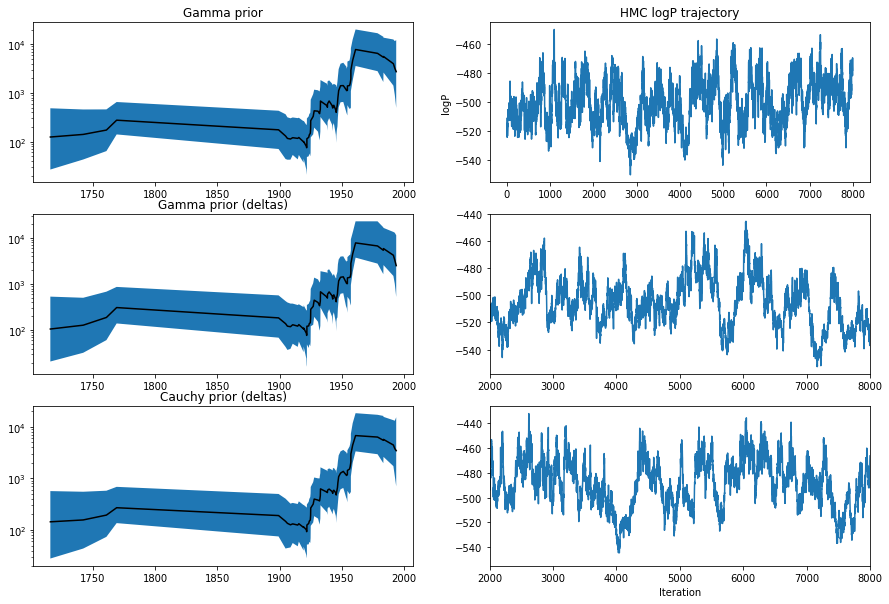

In [131]:
f, axes = plt.subplots(3, 2, figsize=(15,10))
burnin=2000

thetas_hmc=np.array(samples)[burnin:,0:-1]
thetas_hmc=np.exp(thetas_hmc)
quants = np.quantile(thetas_hmc, (0.025, 0.5, 0.975), 0)

axes[0,0].plot(times, quants[1], 'k-')
axes[0,0].fill_between(times, quants[0], quants[2])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Gamma prior')

thetas_hmc_g_deltas = np.array(samples_g_deltas)[burnin:,0:-1]
thetas_hmc_g_deltas = np.exp(thetas_hmc_g_deltas.cumsum(1))
quants = np.quantile(thetas_hmc_g_deltas, (0.025, 0.5, 0.975), 0)

axes[1,0].plot(times, quants[1], 'k-')
axes[1,0].fill_between(times, quants[0], quants[2])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Gamma prior (deltas)')

thetas_hmc_nc=np.array(samples_nc)[burnin:,0:-1]
thetas_hmc_nc=np.exp(thetas_hmc_nc.cumsum(1))
quants = np.quantile(thetas_hmc_nc, (0.025, 0.5, 0.975), 0)

axes[2,0].plot(times, quants[1], 'k-')
axes[2,0].fill_between(times, quants[0], quants[2])
axes[2,0].set_yscale('log')
axes[2,0].set_title('Cauchy prior (deltas)')


axes[0,1].plot(probs[burnin:])
axes[0,1].set_title('HMC logP trajectory')
axes[0,1].set_ylabel('logP')

axes[1,1].plot(probs_g_deltas[burnin:])
axes[1,1].set_xlim([burnin, len(probs_g_deltas)-burnin])

axes[2,1].plot(probs_nc[burnin:])
axes[2,1].set_xlabel('Iteration')
axes[2,1].set_xlim([burnin, len(probs_nc)-burnin])
plt.show()

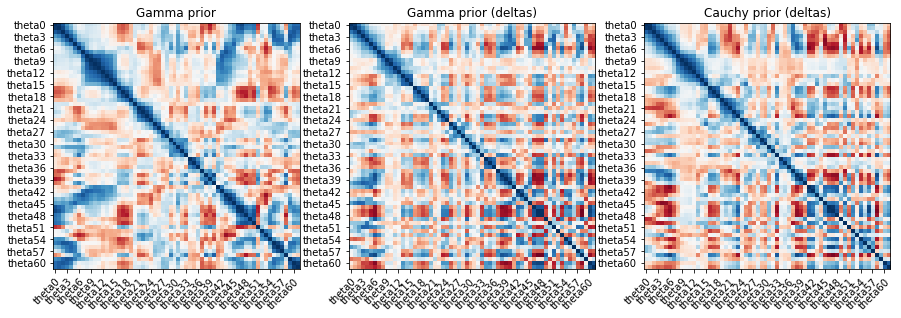

In [132]:
f, axes = plt.subplots(1, 3, figsize=(15,10))

axes[0].set_xticks(np.arange(0, thetas_hmc.shape[1], 3))
axes[0].set_yticks(np.arange(0, thetas_hmc.shape[1], 3))
axes[0].imshow(np.corrcoef(np.cov(np.transpose(thetas_hmc))), vmin=-1, vmax=1, cmap='RdBu')
axes[0].set_xticklabels(['theta{}'.format(i) for i in np.arange(0, thetas_hmc.shape[1], 3)])
axes[0].set_yticklabels(['theta{}'.format(i) for i in np.arange(0, thetas_hmc.shape[1], 3)])
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes[0].set_title('Gamma prior')

axes[1].set_xticks(np.arange(0, thetas_hmc_g_deltas.shape[1], 3))
axes[1].set_yticks(np.arange(0, thetas_hmc_g_deltas.shape[1], 3))
axes[1].imshow(np.corrcoef(np.cov(np.transpose(thetas_hmc_g_deltas))), vmin=-1, vmax=1, cmap='RdBu')
axes[1].set_xticklabels(['theta{}'.format(i) for i in np.arange(0, thetas_hmc_g_deltas.shape[1], 3)])
axes[1].set_yticklabels(['theta{}'.format(i) for i in np.arange(0, thetas_hmc_g_deltas.shape[1], 3)])
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes[1].set_title('Gamma prior (deltas)')

axes[2].set_xticks(np.arange(0, thetas_hmc_nc.shape[1], 3))
axes[2].set_yticks(np.arange(0, thetas_hmc_nc.shape[1], 3))
im = axes[2].imshow(np.corrcoef(np.cov(np.transpose(thetas_hmc_nc))), vmin=-1, vmax=1, cmap='RdBu')
axes[2].set_xticklabels(['theta{}'.format(i) for i in np.arange(0, thetas_hmc_nc.shape[1], 3)])
axes[2].set_yticklabels(['theta{}'.format(i) for i in np.arange(0, thetas_hmc_nc.shape[1], 3)])
plt.setp(axes[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes[2].set_title('Cauchy prior (deltas)')

# plt.colorbar(im, ax=axes[2])
plt.show()